In [225]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt 
import pmdarima as pm
from matplotlib.widgets import Slider, Button
import seaborn as sns 
import plotly.express as px 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from numpy import log
import statsmodels as sm
import statsmodels.api as sm

In [52]:

# Usar dataset
df_ventas = pd.read_feather('Ventas3.feather')

# Acotar a meses completos
df_ventas = df_ventas.query("FH_Entrega > '2016-11-01 00:00:00' and FH_Entrega < '2018-10-01 00:00:00'")


In [53]:

df_ventas.shape


(99364, 16)

In [54]:

df_ventas.dtypes


Id_Pedidos                    object
Precio_Producto              float64
Precio_Flete                 float64
Categoria_Producto            object
Estatus_Pedido                object
FH_Pedido             datetime64[ns]
FH_Aprobacion         datetime64[ns]
FH_Entrega            datetime64[ns]
F_Estimada_Entrega    datetime64[ns]
Ciudad                        object
Estado                        object
Calificacion                   int64
Year                          object
Meses                         object
Dia                           object
Periodo                       object
dtype: object

In [55]:

# Crear el perido diario
df_ventas['Dia'] = df_ventas['Dia'].map({'1':'01','2':'02','3':'03','4':'04','5':'05',
                                         '6':'06','7':'07','8':'08','9':'09','10':'10',
                                         '11':'11','12':'12','13':'13','14':'14','15':'15',
                                         '16':'16','17':'17','18':'18','19':'19','20':'20',
                                         '21':'21','22':'22','23':'23','24':'24','25':'25',
                                         '26':'26','27':'27','28':'28','29':'29','30':'30',
                                         '31':'31'
                                        })
df_ventas = df_ventas.assign(aaaa_mm_dd = "0000_00_00")
df_ventas['aaaa_mm_dd'] = df_ventas[['Year','Meses','Dia']].agg("_".join, axis = 1)

In [56]:

# Crear el periodo semanal
df_ventas = df_ventas.assign(Semana = df_ventas['FH_Entrega'].dt.isocalendar().week)
df_ventas = df_ventas.assign(Year_Semana = "0000_00")
df_ventas['Semana'] = df_ventas['Semana'].map({
                                1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09',10:'10'
                                ,11:'11',12:'12',13:'13',14:'14',15:'15',16:'16',17:'17',18:'18',19:'19',20:'20'
                                ,21:'21',22:'22',23:'23',24:'24',25:'25',26:'26',27:'27',28:'28',29:'29',30:'30'
                                ,31:'31',32:'32',33:'33',34:'34',35:'35',36:'36',37:'37',38:'38',39:'39',40:'40'
                                ,41:'41',42:'42',43:'43',44:'44',45:'45',46:'46',47:'47',48:'48',49:'49',50:'50'
                                ,51:'51',52:'52'})
df_ventas['Year_Semana'] = df_ventas[['Year','Semana']].agg("_".join, axis = 1)


In [57]:

# Grafica de ventas diarias
df_vd = df_ventas.groupby('aaaa_mm_dd')['aaaa_mm_dd'].count()

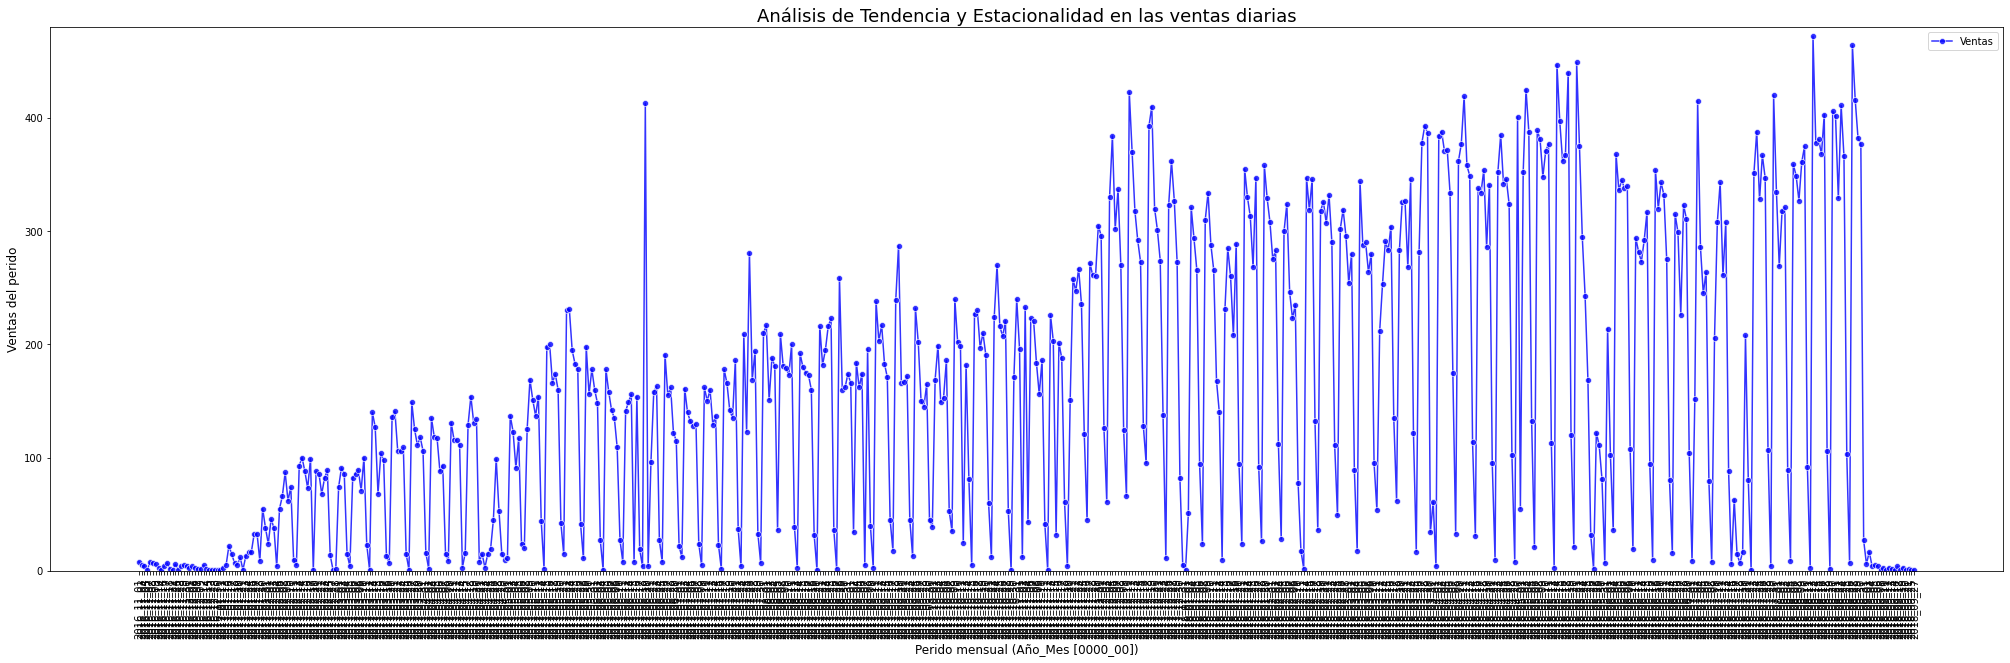

In [58]:
plt.figure(figsize=(35,10))
ax = sns.lineplot(x = df_vd.index, y = df_vd.values, alpha = 0.8, linestyle = '-', marker = 'o', color = 'b', label = 'Ventas')
plt.title('Análisis de Tendencia y Estacionalidad en las ventas diarias', fontsize=18)
plt.ylabel('Ventas del perido', fontsize=12)
plt.xlabel('Perido mensual (Año_Mes [0000_00])', fontsize=12)
plt.xticks(rotation=90)
plt.ylim(0,480) 
plt.legend()
plt.show()

In [59]:
# Grafica de ventas semanales
df_vs = df_ventas['Year_Semana'].value_counts() # No mantiene orden en los indices
df_vs = df_ventas.groupby('Year_Semana')['Year_Semana'].count()
df_vs.describe()

count      99.000000
mean     1003.676768
std       650.273252
min         1.000000
25%       508.000000
50%       978.000000
75%      1573.000000
max      2154.000000
Name: Year_Semana, dtype: float64

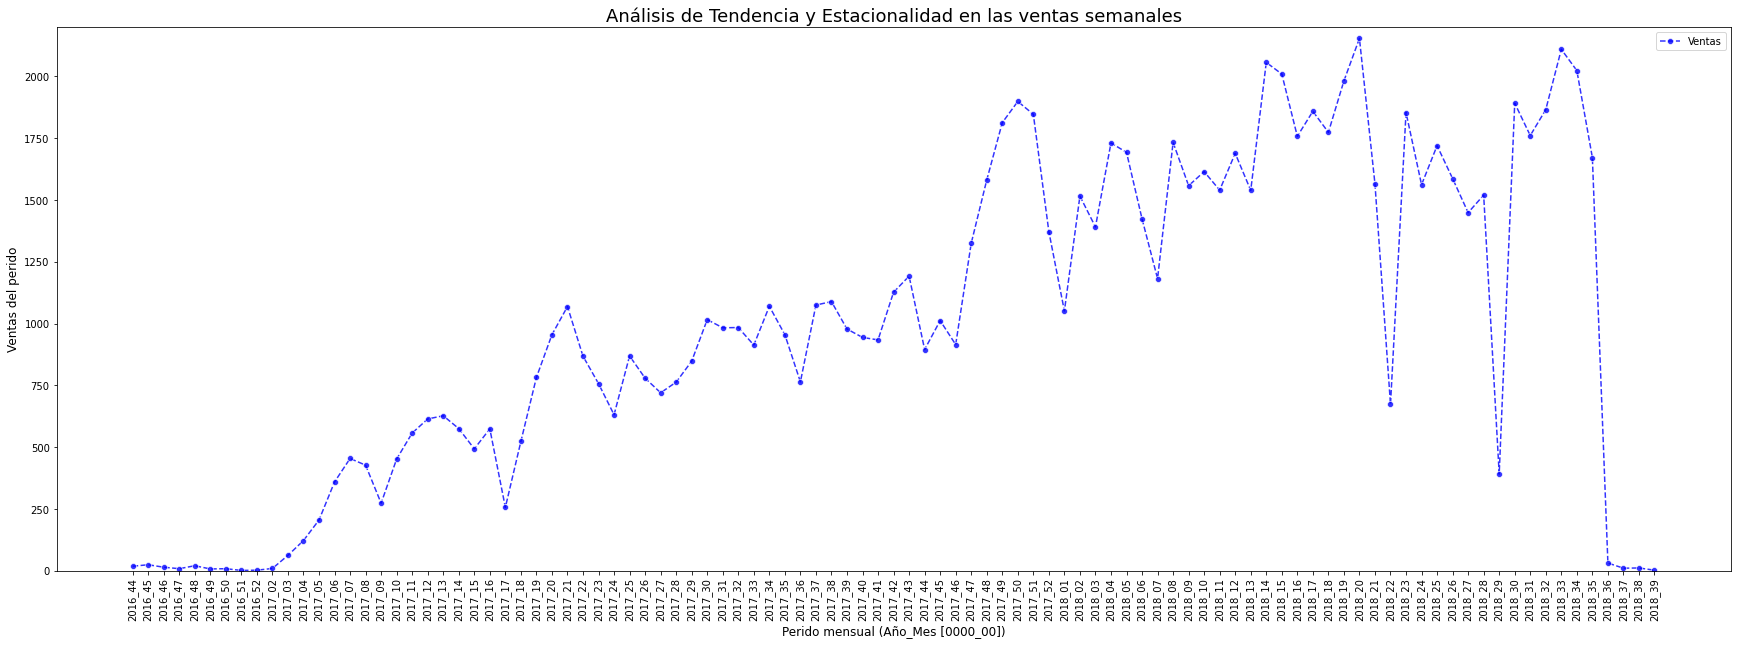

In [60]:

plt.figure(figsize=(30,10))
ax = sns.lineplot(x = df_vs.index, y = df_vs.values, alpha = 0.8, linestyle = '--', marker = 'o', color = 'b', label = 'Ventas')
plt.title('Análisis de Tendencia y Estacionalidad en las ventas semanales', fontsize=18)
plt.ylabel('Ventas del perido', fontsize=12)
plt.xlabel('Perido mensual (Año_Mes [0000_00])', fontsize=12)
plt.xticks(rotation=90)
plt.ylim(0,2200) 
plt.legend()
plt.show()

In [61]:
#Borrar datos atipicos enocntrados en la grafica

df_vs = df_vs.drop(['2016_44','2016_45','2016_46','2016_47','2016_48','2016_49','2016_50','2016_51','2016_52','2018_36','2018_37','2018_38','2018_39'])
df_vs 

Year_Semana
2017_02       9
2017_03      62
2017_04     122
2017_05     205
2017_06     359
           ... 
2018_31    1761
2018_32    1866
2018_33    2110
2018_34    2024
2018_35    1672
Name: Year_Semana, Length: 86, dtype: int64

# Datos definitivos

## Semanal

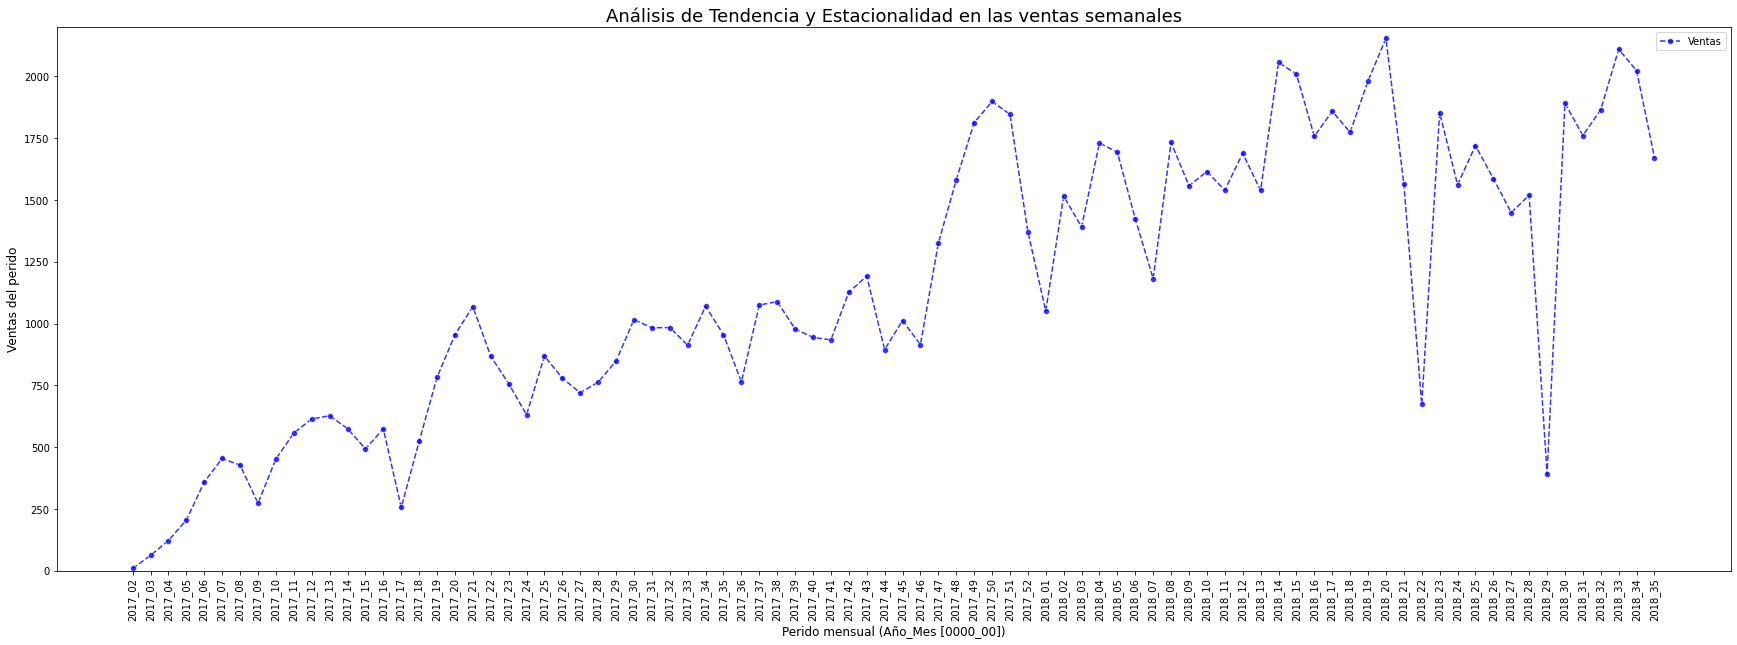

In [62]:
plt.figure(figsize=(30,10))
ax = sns.lineplot(x = df_vs.index, y = df_vs.values, alpha = 0.8, linestyle = '--', marker = 'o', color = 'b', label = 'Ventas')
plt.title('Análisis de Tendencia y Estacionalidad en las ventas semanales', fontsize=18)
plt.ylabel('Ventas del perido', fontsize=12)
plt.xlabel('Perido mensual (Año_Mes [0000_00])', fontsize=12)
plt.xticks(rotation=90)
plt.ylim(0,2200) 
plt.legend()
plt.show()

# Arima

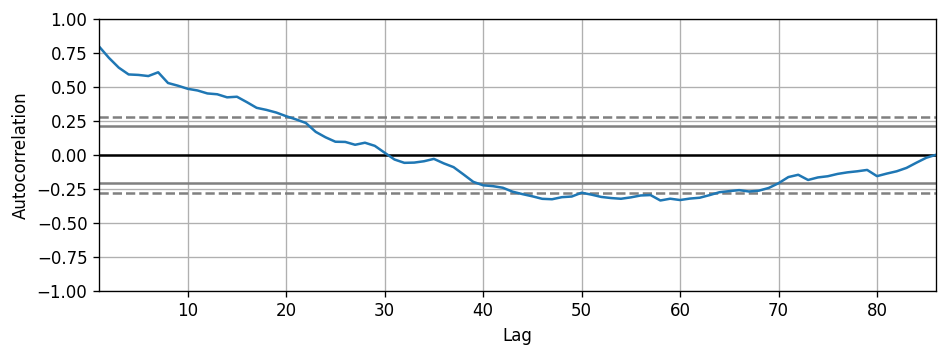

In [232]:
#Correlación de la serie de tiempo --- Grafica 1
def parser(x):
    return datetime.strptime('2017_02'+x, '%Y_%m')
 
series = df_vs 
autocorrelation_plot(series)
plt.show()

C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible start

                               SARIMAX Results                                
Dep. Variable:            Year_Semana   No. Observations:                   86
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -597.005
Date:                Sat, 26 Nov 2022   AIC                           1202.011
Time:                        22:55:12   BIC                           1211.734
Sample:                             0   HQIC                          1205.919
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2855      0.108      2.644      0.008       0.074       0.497
ma.L1         -1.8723      0.112    -16.656      0.000      -2.093      -1.652
ma.L2          0.8724      0.104      8.408      0.0

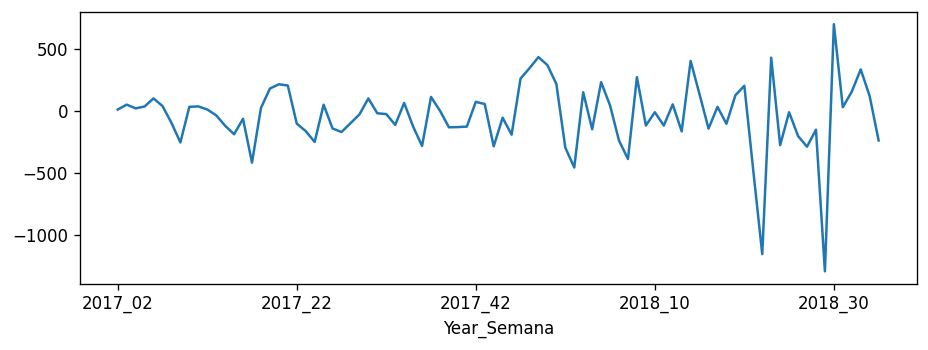

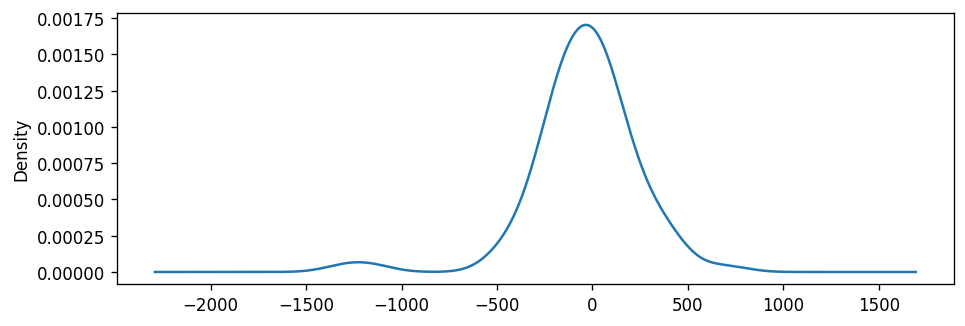

count      86.000000
mean      -42.034250
std       280.597150
min     -1295.647458
25%      -152.948521
50%       -17.004548
75%        98.733743
max       697.159549
dtype: float64


In [238]:
#Srima
def parser(x):
	return datetime.strptime('2017_02'+x, '%Y_%m')
 
series = df_vs 

# fit model
model = ARIMA(series, order=(1,2,2)) 
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = model_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [239]:
def parser(x):
    return datetime.strptime('2017_02'+x,'%Y-%m')

series = df_vs 

#Test de entrenamiento 

X = series.values
size = int(len(X) * 0.33)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#Validación 

for t in range(len(test)):
    model = ARIMA(history, order=(1,2,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Pronostico=%f, Esperado=%f' % (yhat, obs))


Pronostico=878.346622, Esperado=1016.000000
Pronostico=1060.473888, Esperado=983.000000
Pronostico=1003.322533, Esperado=984.000000
Pronostico=1026.851878, Esperado=913.000000
Pronostico=926.879802, Esperado=1070.000000
Pronostico=1116.908448, Esperado=955.000000
Pronostico=971.835488, Esperado=764.000000
Pronostico=797.965105, Esperado=1075.000000
Pronostico=1106.187430, Esperado=1089.000000
Pronostico=1115.966182, Esperado=978.000000
Pronostico=994.204188, Esperado=944.000000
Pronostico=972.224784, Esperado=934.000000
Pronostico=950.027794, Esperado=1127.000000
Pronostico=1171.216663, Esperado=1192.000000
Pronostico=1201.450577, Esperado=895.000000
Pronostico=900.587443, Esperado=1012.000000
Pronostico=1058.257106, Esperado=915.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Pronostico=905.339315, Esperado=1325.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=1202.403635, Esperado=1581.000000
Pronostico=1579.044277, Esperado=1813.000000
Pronostico=1879.901590, Esperado=1899.000000
Pronostico=1910.359844, Esperado=1847.000000
Pronostico=1912.130078, Esperado=1372.000000
Pronostico=1414.855332, Esperado=1051.000000
Pronostico=1155.469535, Esperado=1516.000000
Pronostico=1525.818486, Esperado=1391.000000
Pronostico=1420.345077, Esperado=1731.000000
Pronostico=1792.834453, Esperado=1693.000000
Pronostico=1687.224301, Esperado=1424.000000
Pronostico=1453.482234, Esperado=1182.000000
Pronostico=1166.649087, Esperado=1733.000000
Pronostico=1837.570939, Esperado=1558.000000
Pronostico=1607.843938, Esperado=1615.000000
Pronostico=1686.248635, Esperado=1540.000000
Pronostico=1587.116359, Esperado=1689.000000
Pronostico=1688.713939, Esperado=1539.000000
Pronostico=1601.850915, Esperado=2057.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Pronostico=1987.825418, Esperado=2010.000000
Pronostico=2127.307293, Esperado=1758.000000
Pronostico=1762.649526, Esperado=1859.000000
Pronostico=1893.341638, Esperado=1774.000000
Pronostico=1828.169945, Esperado=1982.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=1953.414686, Esperado=2154.000000
Pronostico=2186.537383, Esperado=1565.000000
Pronostico=1623.751695, Esperado=673.000000
Pronostico=642.019497, Esperado=1854.000000
Pronostico=1906.716757, Esperado=1562.000000
Pronostico=1776.042717, Esperado=1720.000000
Pronostico=1850.931160, Esperado=1587.000000
Pronostico=1785.551368, Esperado=1449.000000
Pronostico=1702.506008, Esperado=1520.000000
Pronostico=1670.677103, Esperado=391.000000
Pronostico=849.309102, Esperado=1892.000000
Pronostico=1579.474110, Esperado=1761.000000
Pronostico=1613.742513, Esperado=1866.000000
Pronostico=1710.974079, Esperado=2110.000000
Pronostico=2080.861287, Esperado=2024.000000
Pronostico=2100.470757, Esperado=1672.000000


Test RMSE: 388.110


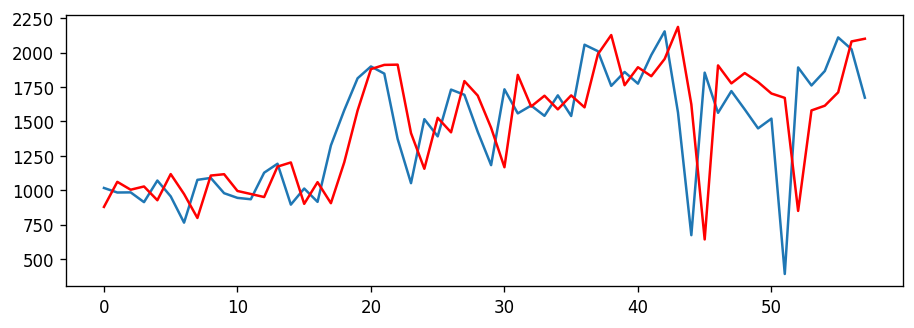

In [244]:
# Grafica pronostico vs datos 

plt.plot(test)
plt.plot(predictions, color='red')
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
plt.show()

### Auto ARIMA

In [246]:
model = pm.auto_arima(df_vs, start_p=1, start_q=1,
                      test='adf',       # optimo 'd'
                      max_p=3, max_q=3, # maximo p y q
                      m=1,              # frecuencia de series
                      d=None,        
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1231.051, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1220.988, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1210.379, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1229.349, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1208.315, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1210.712, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1209.113, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1210.909, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1212.192, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.815 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(0, 1, 2)   Log Likelihood             

### Auto ARIMA

In [250]:
def parser(x):
    return datetime.strptime()

series = df_vs

#Test de entrenamiento 

X = series.values
size = int(len(X) * 0.33)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#Validación 

for t in range(len(test)):
    model = ARIMA(history, order=(0,1,2)) #Valores de auto ARIMA
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Pronostico=%f, Esperado=%f' % (yhat, obs))

Pronostico=845.683470, Esperado=1016.000000
Pronostico=1021.958090, Esperado=983.000000
Pronostico=972.629350, Esperado=984.000000
Pronostico=986.057155, Esperado=913.000000
Pronostico=910.128297, Esperado=1070.000000
Pronostico=1075.278650, Esperado=955.000000
Pronostico=949.111075, Esperado=764.000000
Pronostico=779.237910, Esperado=1075.000000
Pronostico=1081.599713, Esperado=1089.000000
Pronostico=1031.852293, Esperado=978.000000
Pronostico=982.254386, Esperado=944.000000
Pronostico=959.315840, Esperado=934.000000
Pronostico=945.424486, Esperado=1127.000000
Pronostico=1113.025678, Esperado=1192.000000
Pronostico=1140.693148, Esperado=895.000000
Pronostico=899.115859, Esperado=1012.000000
Pronostico=1062.342589, Esperado=915.000000
Pronostico=913.753700, Esperado=1325.000000
Pronostico=1255.547857, Esperado=1581.000000
Pronostico=1445.535682, Esperado=1813.000000
Pronostico=1814.923943, Esperado=1899.000000
Pronostico=1905.060364, Esperado=1847.000000
Pronostico=1844.139286, Esperad

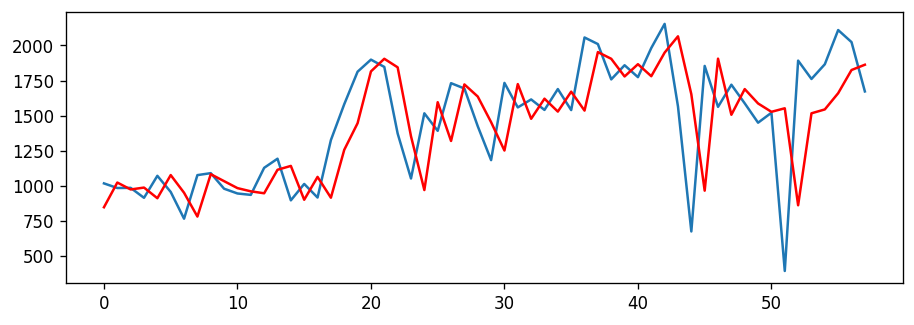

Test RMSE: 359.011


In [252]:
# Grafica pronostico vs datos 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

### Conclusiones semanal 

De la serie de tiempo de ventas E - commerce Brasil

1. Al tomar los valores optimos de los parametros d,p,q gracias a auto arima respecto a valores dados por el analisis de validación cruzada, se nota un valor de error cuadratico medio de 359 más bajo respecto a valor resultante de la validación cruzada, por lo cual se puede decir que el prónostico es más confiable. 


## Diario

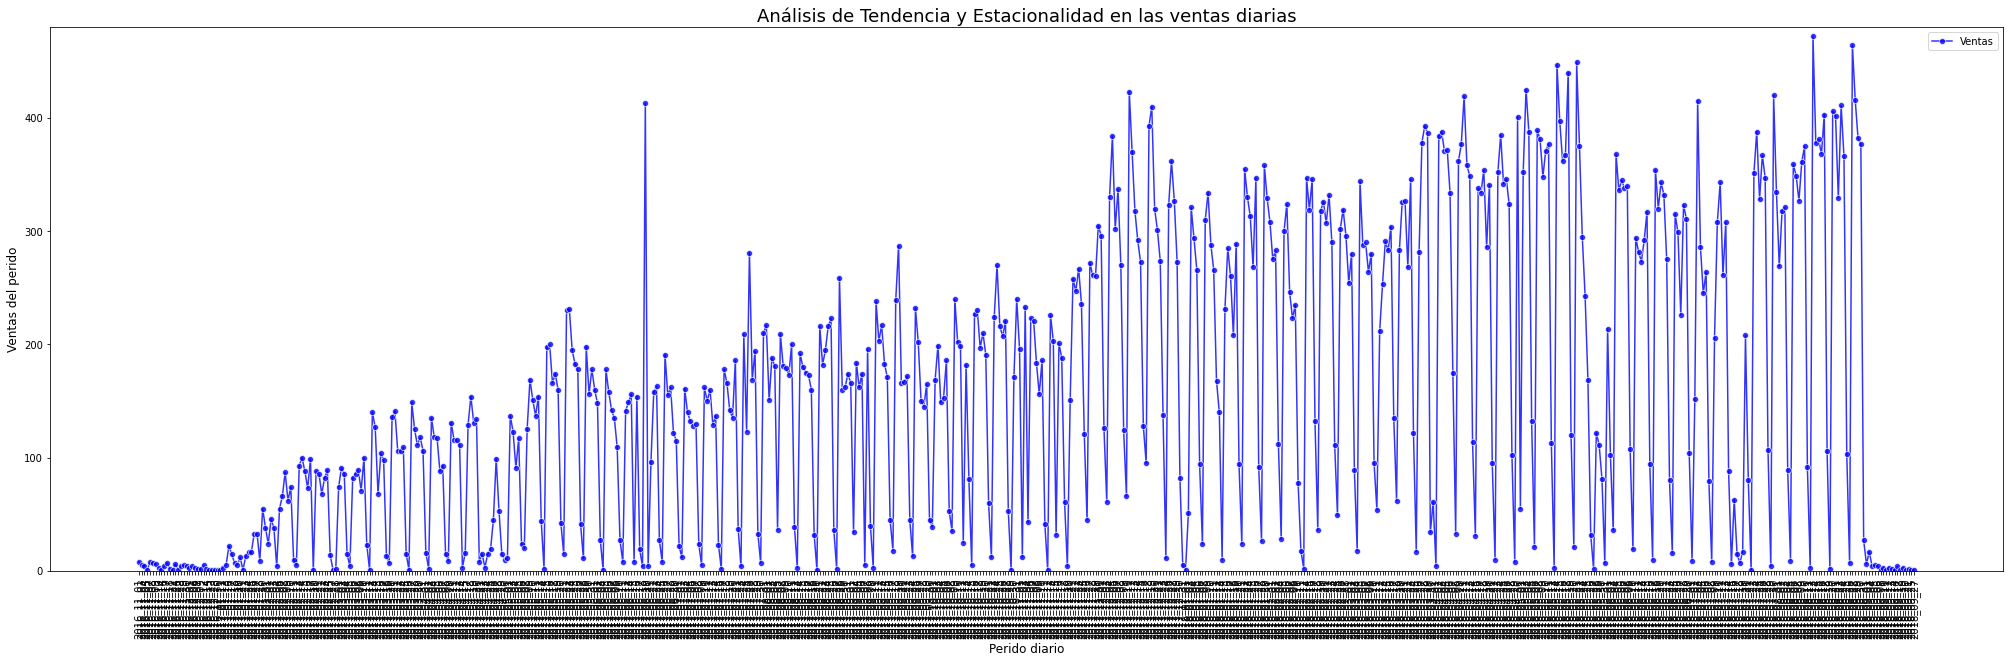

In [66]:
plt.figure(figsize=(35,10))
ax = sns.lineplot(x = df_vd.index, y = df_vd.values, alpha = 0.8, linestyle = '-', marker = 'o', color = 'b', label = 'Ventas')
plt.title('Análisis de Tendencia y Estacionalidad en las ventas diarias', fontsize=18)
plt.ylabel('Ventas del perido', fontsize=12)
plt.xlabel('Perido diario', fontsize=12)
plt.xticks(rotation=90)
plt.ylim(0,480) 
plt.legend()
plt.show()

## Arima

In [68]:
# Identificar si la serie es estacional
result = adfuller(df_vd.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.378688
p-value: 0.147842


Valor de P- value es mayor a 0.05, por lo tanto se conclue que si hay estacionalidad en la serie de tiempo

### Parametro (d)

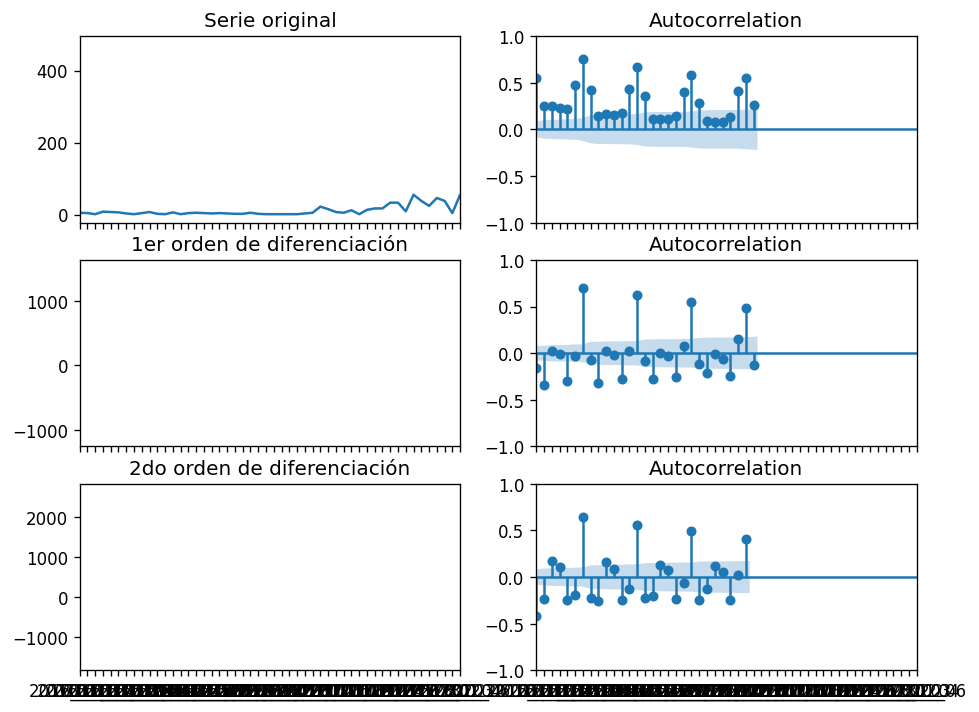

In [138]:
#Gráfico de autocorrelación

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

#Serie original
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_vd); axes[0, 0].set_title('Serie original')
axes[0,1].set_xlim([1,50])
plot_acf(df_vd, ax=axes[0, 1])


# Primera Diferenciación
axes[1, 0].plot(df_vs.diff()); axes[1, 0].set_title('1er orden de diferenciación')
plot_acf(df_vd.diff().dropna(), ax=axes[1, 1])

# Segunda Diferenciación
axes[2, 0].plot(df_vs.diff().diff()); axes[2, 0].set_title("2do orden de diferenciación")
plot_acf(df_vd.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Al evidenciar el primer orden de difenciación se nota una tendencia negativa al igaul que la autocorrelación respecto al segundo orden de diferenciación, por lo tanto se concluye **d=1**, dado que no hay una diferencia significativa.

### Parametro (p)

C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


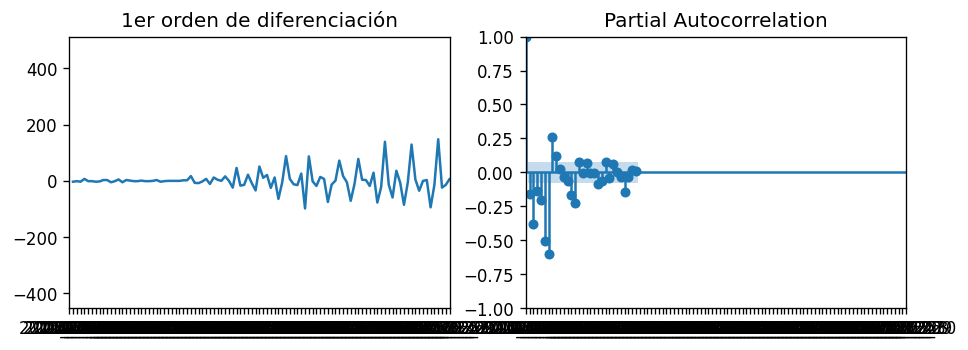

In [141]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_vd.diff()); axes[0].set_title("1er orden de diferenciación")
axes[1].set(xlim=(0,100))
plot_pacf(df_vd.diff().dropna(), ax=axes[1])
plt.show()

Se puede observar que el lag 1 está por debajo del límite (zona azul) por cual se concluye que **p=2**.

### Parametro (q)

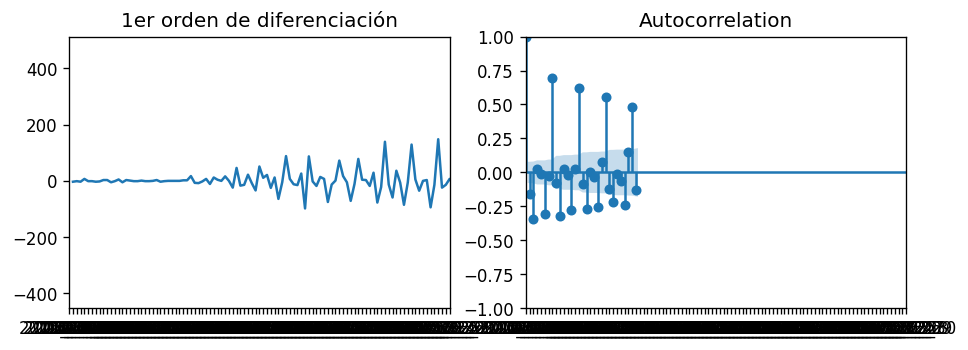

In [143]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_vd.diff()); axes[0].set_title('1er orden de diferenciación')
axes[1].set(xlim=(0,100))
plot_acf(df_vd.diff().dropna(), ax=axes[1])

plt.show()

Se puede observar que el lag 1 está por debajo del límite (zona azul) por cual se concluye que **q=2**.

### Variables 

Los siguientes serán los párametros para realizar el modelo arima  

**d = 1**
**p = 2**
**q = 2**

### Tabla ARIMA

In [159]:
model = ARIMA(df_vd, order=(1,2,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             aaaa_mm_dd   No. Observations:                  632
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -3922.856
Date:                Sat, 26 Nov 2022   AIC                           7853.713
Time:                        20:32:58   BIC                           7871.496
Sample:                             0   HQIC                          7860.620
                                - 632                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8495      0.060    -14.224      0.000      -0.967      -0.732
ma.L1         -0.0761      0.735     -0.103      0.918      -1.517       1.365
ma.L2         -0.9234      0.687     -1.344      0.1

### Análisis de la media constante y la varianza

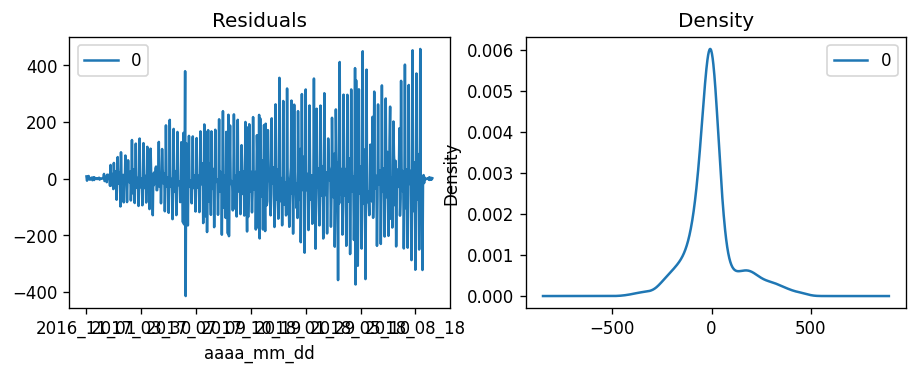

                0
count  632.000000
mean    -0.460248
std    121.920837
min   -414.117055
25%    -49.020331
50%     -5.979957
75%     21.080395
max    457.737947


In [187]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())

Lo errores residuales están cerca a cero y varianza es uniforme.

### Gráfica actual vs ajustada

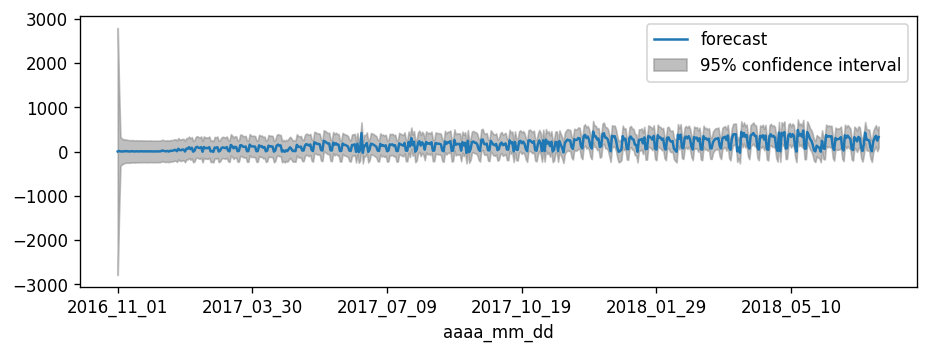

In [184]:
plot_predict(model_fit, "2016_11_01","2018_07_14", dynamic=False,)
plt.show()

La tendencia de los datos muestra un comportamientocreciente, donde se tiene en cuenta que el modelo pronosticado tiene un ajuste aceptable respecto al historico de los datos.

### Auto ARIMA

In [227]:
model = pm.auto_arima(df_vd, start_p=1, start_q=1,
                      test='adf',       # optimo 'd'
                      max_p=3, max_q=3, # maximo p y q
                      m=1,              # frecuencia de series
                      d=None,        
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7725.901, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8517.731, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7819.625, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8070.458, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7807.100, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7623.076, Time=1.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7962.262, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7621.557, Time=1.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7598.333, Time=1.63 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7616.657, Time=1.40 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=7472.399, Time=2.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=7608.355, Time=1.51 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7551.279, Time=2.89 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 14.458 seconds
                     

## Modelo optimo ARIMA 

In [228]:
def parser(x):
    return datetime.strptime()

series = df_vd 

#Test de entrenamiento 

X = series.values
size = int(len(X) * 0.33)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#Validación 

for t in range(len(test)):
    model = ARIMA(history, order=(3,0,3)) #Valores de auto ARIMA
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Pronostico=%f, Esperado=%f' % (yhat, obs))

C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=32.565097, Esperado=178.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=128.112262, Esperado=166.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=103.596549, Esperado=142.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=171.313489, Esperado=135.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=53.798995, Esperado=186.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=78.979751, Esperado=37.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=-25.869860, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=74.827397, Esperado=209.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=135.144200, Esperado=123.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=121.408048, Esperado=281.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=203.788772, Esperado=169.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=80.722928, Esperado=194.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=119.920319, Esperado=33.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=132.127638, Esperado=7.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=86.569987, Esperado=210.000000
Pronostico=110.855792, Esperado=217.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=156.943784, Esperado=151.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=112.728899, Esperado=188.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=163.323223, Esperado=181.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=123.363252, Esperado=36.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=34.561628, Esperado=209.000000
Pronostico=136.534440, Esperado=181.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=110.120190, Esperado=179.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=135.729406, Esperado=173.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=160.826566, Esperado=200.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=137.115767, Esperado=39.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=131.381335, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=134.720053, Esperado=192.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=145.054494, Esperado=180.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=114.813080, Esperado=175.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=156.501875, Esperado=173.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=134.636904, Esperado=160.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=134.246630, Esperado=32.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=136.800111, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=152.411776, Esperado=216.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=133.439634, Esperado=182.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=147.071737, Esperado=195.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=136.144369, Esperado=216.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=154.227711, Esperado=223.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=117.371435, Esperado=36.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=99.841455, Esperado=2.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=138.295814, Esperado=259.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=147.528500, Esperado=160.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=130.193141, Esperado=162.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=149.152028, Esperado=174.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=152.319576, Esperado=166.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=178.612737, Esperado=34.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=99.011785, Esperado=184.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=195.763248, Esperado=162.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=154.530387, Esperado=174.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=95.193448, Esperado=5.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=150.140141, Esperado=196.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.353141, Esperado=40.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=88.053639, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=105.560690, Esperado=238.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=188.290220, Esperado=203.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=108.509348, Esperado=217.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=94.441428, Esperado=183.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.069456, Esperado=171.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=118.018912, Esperado=45.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=107.409080, Esperado=18.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=175.885458, Esperado=239.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=185.073983, Esperado=287.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=100.651133, Esperado=166.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=142.521326, Esperado=167.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=203.857042, Esperado=172.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=128.966738, Esperado=45.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=130.413737, Esperado=13.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=201.500661, Esperado=232.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=176.672881, Esperado=202.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=74.356987, Esperado=150.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=157.832578, Esperado=145.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=186.950519, Esperado=165.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=112.632749, Esperado=45.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=113.566014, Esperado=39.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=173.399433, Esperado=169.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=140.592963, Esperado=199.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=104.889477, Esperado=149.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=152.581450, Esperado=153.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=163.264584, Esperado=186.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=123.900438, Esperado=53.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=122.525778, Esperado=35.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.229169, Esperado=240.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=150.020997, Esperado=202.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=75.586030, Esperado=199.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=154.801948, Esperado=25.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=145.280774, Esperado=182.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=143.625965, Esperado=81.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=102.461155, Esperado=5.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=173.944508, Esperado=227.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=153.539046, Esperado=230.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=84.120430, Esperado=197.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=153.306075, Esperado=210.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=197.095289, Esperado=191.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=117.761702, Esperado=60.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=116.989202, Esperado=12.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.076380, Esperado=224.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=154.901311, Esperado=270.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=92.472165, Esperado=216.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=147.337272, Esperado=207.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=208.000958, Esperado=221.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=129.996696, Esperado=53.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=127.072966, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=195.005527, Esperado=171.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=157.549826, Esperado=240.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=117.507266, Esperado=196.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=147.739235, Esperado=12.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=156.962916, Esperado=233.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=172.668517, Esperado=43.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=113.082026, Esperado=223.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=195.285116, Esperado=221.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=158.402896, Esperado=184.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=108.670393, Esperado=156.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=173.343584, Esperado=186.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=192.794963, Esperado=41.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=113.651601, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=129.969449, Esperado=226.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=215.980048, Esperado=203.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=114.045671, Esperado=32.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=88.683297, Esperado=201.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=229.493820, Esperado=188.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=137.636580, Esperado=61.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=69.903101, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=184.287820, Esperado=151.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=180.264598, Esperado=258.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=86.483647, Esperado=247.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=155.846386, Esperado=267.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=208.366671, Esperado=236.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=121.984951, Esperado=121.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=129.777606, Esperado=45.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.555046, Esperado=272.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=180.443818, Esperado=261.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=120.336483, Esperado=260.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=185.642512, Esperado=305.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=217.327833, Esperado=296.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=159.012227, Esperado=126.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=159.448555, Esperado=61.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=206.517958, Esperado=330.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=213.056334, Esperado=384.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=169.922167, Esperado=302.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=203.087259, Esperado=337.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=266.762075, Esperado=270.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=205.593740, Esperado=124.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=185.730520, Esperado=66.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=234.120415, Esperado=423.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=271.820027, Esperado=370.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=179.350403, Esperado=318.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=239.397421, Esperado=292.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=304.324380, Esperado=273.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=224.129348, Esperado=128.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=195.949107, Esperado=95.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=267.553877, Esperado=393.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=287.794809, Esperado=410.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=206.739823, Esperado=320.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=256.680704, Esperado=301.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=316.480930, Esperado=274.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=237.894647, Esperado=138.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=211.549586, Esperado=11.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=251.995527, Esperado=323.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=294.707449, Esperado=362.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=214.621884, Esperado=327.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=244.203508, Esperado=273.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=298.948610, Esperado=82.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.092206, Esperado=5.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=192.222923, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=235.668701, Esperado=51.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=168.086537, Esperado=321.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=221.957186, Esperado=294.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=229.244247, Esperado=266.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=196.365968, Esperado=94.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=180.748061, Esperado=24.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.122671, Esperado=310.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=255.607884, Esperado=334.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=198.403819, Esperado=288.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=305.938663, Esperado=266.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=252.949003, Esperado=168.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=197.095620, Esperado=140.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=181.049683, Esperado=10.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.408315, Esperado=231.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=270.308948, Esperado=285.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=196.575168, Esperado=260.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=192.808261, Esperado=208.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=226.405289, Esperado=289.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=236.075162, Esperado=94.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=149.562445, Esperado=24.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=178.806732, Esperado=355.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=301.294051, Esperado=330.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=177.421108, Esperado=313.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=181.906351, Esperado=268.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=288.429837, Esperado=347.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=240.560994, Esperado=92.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=128.251030, Esperado=26.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=231.251949, Esperado=358.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=315.712047, Esperado=329.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=146.313354, Esperado=308.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=219.343186, Esperado=275.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=311.499764, Esperado=283.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=200.341648, Esperado=112.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=165.979284, Esperado=28.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=254.673444, Esperado=300.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=272.684399, Esperado=324.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=180.253435, Esperado=246.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=223.223756, Esperado=223.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=268.912895, Esperado=235.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=203.735689, Esperado=78.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=168.716952, Esperado=18.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=212.292434, Esperado=2.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=178.340164, Esperado=347.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=250.696460, Esperado=319.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=216.769270, Esperado=346.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=211.511922, Esperado=132.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.182920, Esperado=36.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=179.972068, Esperado=318.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=274.953324, Esperado=326.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=216.410694, Esperado=307.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=192.317163, Esperado=332.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=281.514296, Esperado=290.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=230.510452, Esperado=111.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=150.511784, Esperado=49.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=227.035480, Esperado=302.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=295.988998, Esperado=319.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=182.826818, Esperado=296.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=217.810499, Esperado=254.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=282.069239, Esperado=280.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=219.607129, Esperado=89.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=158.791691, Esperado=18.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=223.555855, Esperado=344.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=302.328644, Esperado=288.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=170.465368, Esperado=290.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=221.412173, Esperado=264.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=291.460274, Esperado=280.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=206.366358, Esperado=95.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=159.631613, Esperado=54.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=243.671781, Esperado=212.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=247.193009, Esperado=253.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=179.796796, Esperado=291.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=244.692968, Esperado=283.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=255.307319, Esperado=304.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=206.186076, Esperado=135.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.867604, Esperado=62.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=214.771817, Esperado=283.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=263.094942, Esperado=326.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=219.651966, Esperado=327.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=225.062746, Esperado=268.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=252.494788, Esperado=346.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=260.459323, Esperado=122.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=169.375627, Esperado=17.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.786677, Esperado=282.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=313.563300, Esperado=378.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=227.892456, Esperado=393.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=215.565679, Esperado=387.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=316.436268, Esperado=34.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=151.366175, Esperado=61.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=192.691219, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=253.100012, Esperado=384.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=271.550580, Esperado=388.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=215.683905, Esperado=371.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=258.049406, Esperado=372.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=286.773886, Esperado=334.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=233.066285, Esperado=175.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=208.772995, Esperado=33.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=216.821596, Esperado=362.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=318.360893, Esperado=377.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=243.730502, Esperado=419.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=250.218437, Esperado=358.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=311.526788, Esperado=349.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=270.567452, Esperado=114.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=180.648202, Esperado=31.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=236.288479, Esperado=338.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=347.892021, Esperado=334.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=217.275750, Esperado=354.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=245.507951, Esperado=286.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=318.613478, Esperado=341.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=261.143229, Esperado=95.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=168.738625, Esperado=10.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=240.532222, Esperado=352.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=352.811350, Esperado=385.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=223.541864, Esperado=342.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=234.068152, Esperado=346.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=343.583990, Esperado=324.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=250.332141, Esperado=102.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=163.134255, Esperado=8.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=257.913482, Esperado=401.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=366.769263, Esperado=55.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=93.816110, Esperado=352.000000
Pronostico=301.533320, Esperado=425.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=390.680852, Esperado=388.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=155.390847, Esperado=132.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=202.646922, Esperado=21.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=317.237901, Esperado=389.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=281.348616, Esperado=381.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=216.395564, Esperado=348.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=300.311900, Esperado=371.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=307.513528, Esperado=377.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=247.026451, Esperado=113.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=215.473980, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=240.468464, Esperado=447.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=359.675540, Esperado=397.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=241.986521, Esperado=362.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=242.194968, Esperado=367.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=354.116098, Esperado=440.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=301.986674, Esperado=120.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=160.937168, Esperado=21.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=272.356836, Esperado=449.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=418.496128, Esperado=375.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.668631, Esperado=295.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=232.520854, Esperado=243.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=377.238790, Esperado=169.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=208.511225, Esperado=32.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=167.617550, Esperado=2.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=308.162035, Esperado=122.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=239.552707, Esperado=111.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=164.968022, Esperado=81.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=249.512624, Esperado=7.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=199.242419, Esperado=214.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=211.042017, Esperado=102.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=191.465722, Esperado=36.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=167.698660, Esperado=368.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=275.874087, Esperado=336.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=209.468623, Esperado=345.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=198.996971, Esperado=338.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=279.675145, Esperado=340.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=246.219400, Esperado=108.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=146.909121, Esperado=19.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=213.877006, Esperado=294.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=313.282873, Esperado=282.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=174.848209, Esperado=273.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=199.155113, Esperado=292.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=309.305171, Esperado=317.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=222.432772, Esperado=94.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=133.423839, Esperado=10.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=239.742016, Esperado=354.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=322.373720, Esperado=320.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=161.241797, Esperado=343.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=232.595407, Esperado=332.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=320.883972, Esperado=275.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=189.172912, Esperado=80.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=160.690439, Esperado=16.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=260.456696, Esperado=315.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=284.409965, Esperado=299.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=175.109514, Esperado=226.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=225.571784, Esperado=323.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=311.480121, Esperado=311.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=207.394971, Esperado=104.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=154.256785, Esperado=9.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=245.313265, Esperado=152.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=246.369034, Esperado=415.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=244.907237, Esperado=286.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=211.498237, Esperado=245.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=235.041887, Esperado=264.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=255.059494, Esperado=79.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=164.229173, Esperado=8.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=180.298449, Esperado=206.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=289.379308, Esperado=308.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=218.306964, Esperado=343.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=201.105942, Esperado=261.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=257.593521, Esperado=308.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=250.425638, Esperado=88.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=141.222590, Esperado=6.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=193.541580, Esperado=63.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=235.854745, Esperado=15.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=125.943616, Esperado=7.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=154.470529, Esperado=17.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=205.013025, Esperado=208.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=190.023633, Esperado=80.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=110.309179, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=144.616952, Esperado=351.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=290.149175, Esperado=388.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=174.997619, Esperado=328.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=213.523983, Esperado=367.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=155.351795, Esperado=347.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=128.559635, Esperado=107.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=132.867343, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=175.901037, Esperado=420.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=286.846525, Esperado=335.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=311.249654, Esperado=269.000000
Pronostico=251.190150, Esperado=318.000000
Pronostico=178.098243, Esperado=321.000000
Pronostico=147.438967, Esperado=89.000000
Pronostico=150.271065, Esperado=9.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=202.433190, Esperado=359.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=309.539589, Esperado=349.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=333.198368, Esperado=327.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=272.687823, Esperado=361.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=194.286122, Esperado=375.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=162.513962, Esperado=92.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=159.443059, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=211.763731, Esperado=472.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=346.765100, Esperado=378.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=372.314353, Esperado=381.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=305.264404, Esperado=368.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=212.396336, Esperado=403.000000
Pronostico=178.853407, Esperado=106.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=179.624219, Esperado=2.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=244.282881, Esperado=406.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=374.973619, Esperado=402.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=404.312793, Esperado=329.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=320.353827, Esperado=411.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=226.056538, Esperado=366.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=177.357799, Esperado=103.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=181.461263, Esperado=7.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=253.429648, Esperado=464.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=396.185662, Esperado=416.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=419.092788, Esperado=382.000000
Pronostico=337.272338, Esperado=377.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=226.296485, Esperado=27.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=130.517487, Esperado=6.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=163.862689, Esperado=17.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=272.349290, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=347.840681, Esperado=5.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=320.195391, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=196.653958, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=40.457266, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=-25.019418, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=13.484469, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=102.209161, Esperado=2.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=160.857544, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=142.730585, Esperado=4.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=57.850108, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=-31.973616, Esperado=3.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=-65.038171, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Pronostico=-26.721517, Esperado=2.000000
Pronostico=43.109214, Esperado=1.000000
Pronostico=90.951828, Esperado=1.000000


C:\Users\Usuario\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


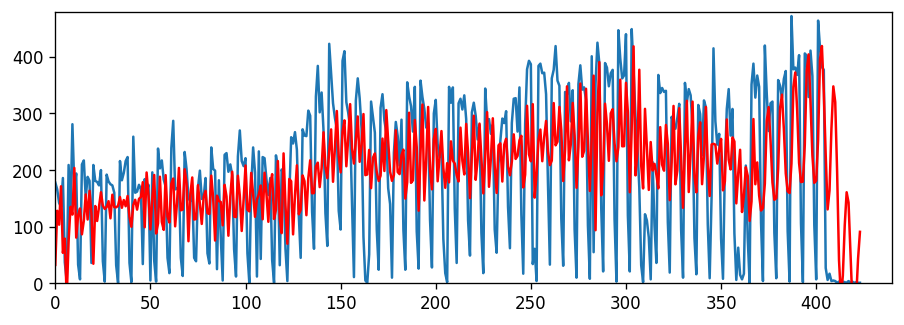

Test RMSE: 111.812


In [230]:
# Grafica pronostico vs datos 
plt.plot(test)
plt.plot(predictions, color='red')
plt.ylim(0,480)
plt.xlim(0,440)
plt.show()
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

### Conclusiones Diario

De la serie de tiempo de ventas E - commerce Brasil

1. Al tomar los valores optimos de los parametros d,p,q gracias a auto arima respecto a valores dados por el analisis de validación cruzada, se nota un valor de error cuadratico medio de 11.812 más bajo que 359  respecto a valor resultante de los datos semales, por lo cual se puede decir que el prónostico es más confiable cuando se usan metodos que proporcionen el parametro optimo y cuando se usan mayor cantidad de datos en la muestra.